<a href="https://colab.research.google.com/github/shubhangsrivastav/Machine-Learning-Projects/blob/main/Time_Series_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# checking the versions of key python libraries & dependencies
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

scipy: 1.4.1
numpy: 1.19.5
matplotlib: 3.2.2
pandas: 1.1.5
statsmodels: 0.10.2
sklearn: 1.0.1


In [ ]:
# mounting the google drive to access the dataset from our drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Problem Description**
The problem is to predict the number of monthly sales of champagne for the Perrin Freres label (named for a region in France).

The dataset provides the number of monthly sales of champagne from January 1964 to September 1972, or just under 10 years of data.

The values are a count of millions of sales and there are 105 observations.

# Validation Dataset
The dataset is not current. This means that we cannot easily collect updated data to validate the model.

Therefore we will pretend that it is September 1971 and withhold the last one year of data from analysis and model selection.

This final year of data will be used to validate the final model.

In [ ]:
# separate out a validation dataset
from pandas import read_csv
series = read_csv('/content/drive/My Drive/French Champagne Time series forecast/monthly_champagne_sales.csv', header=0,  index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('/content/drive/My Drive/French Champagne Time series forecast/dataset.csv', header=False)
validation.to_csv('/content/drive/My Drive/French Champagne Time series forecast/validation.csv', header=False)

Dataset 93, Validation 12


***Baseline Prediction***:   
Now, we will write a simple code that would provide us a baseline prediction and the mena-squared error pertaining to it.
In the bellow code we have simply estimated the sales of (i)th month as the sales of (i+1)th month and calculated the mean-squared error. Observe how big of a value the mean-squared error holds

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=4121.000, Expected=4647
>Predicted=4647.000, Expected=4753
>Predicted=4753.000, Expected=3965
>Predicted=3965.000, Expected=1723
>Predicted=1723.000, Expected=5048
>Predicted=5048.000, Expected=6922
>Predicted=6922.000, Expected=9858
>Predicted=9858.000, Expected=11331
>Predicted=11331.000, Expected=4016
>Predicted=4016.000, Expected=3957
>Predicted=3957.000, Expected=4510
>Predicted=4510.000, Expected=4276
>Predicted=4276.000, Expected=4968
>Predicted=4968.000, Expected=4677
>Predicted=4677.000, Expected=3523
>Predicted=3523.000, Expected=1821
>Predicted=1821.000, Expected=5222
>Predicted=5222.000, Expected=6872
>Predicted=6872.000, Expected=10803
>Predicted=10803.000, Expected=13916
>Predicted=13916.000, Expected=2639
>Predicted=2639.000, Expected=2899
>Predicted=2899.000, Expected=3370
>Predicted=3370.000, Expected=3740
>Predicted=3740.000, Expected=2927
>Predicted=2927.000, Expected=3986
>Predicted=3986.000, Expected=4217
>Predicted=4217.000, Expected=1738
>Predicted=173

# **Data Analysis**
Moving on to the actual forecasting and analysis part.
We can use summary statistics and plots of the data to quickly learn more about the structure of the prediction problem.

In this section, we will look at the data from five perspectives:

*   Summary Statistics
*   Line Plot
*   Seasonal Line Plots
*   Density Plots
*   Box & Whisker Plots







## Summary Statistics
Summary statistics provide a quick look at the limits of observed values. It can help to get a quick idea of what we are working with.

In [ ]:
# ------SUMMARY STATISTICS-------
dataset.describe()

count       93.000000
mean      4641.118280
std       2486.403841
min       1573.000000
25%       3036.000000
50%       4016.000000
75%       5048.000000
max      13916.000000
Name: Sales, dtype: float64

## Line Plot
Some observations from the plot include:

*   There may be an increasing trend of sales over time.
*   There appears to be systematic seasonality to the sales for each year.
*   The seasonal signal appears to be growing over time, suggesting a multiplicative relationship (increasing change).
*   There do not appear to be any obvious outliers.
*   The seasonality suggests that the series is almost certainly non-stationary.




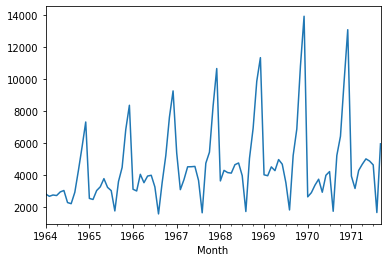

In [ ]:
# --------LINE PLOT---------
import matplotlib.pyplot as plt
dataset.plot()
plt.show()

## Seasonal Line Plots
We can confirm the assumption that the seasonality is a yearly cycle by eyeballing line plots of the dataset by year.
We can clearly see a dip each August and a rise from each August to December. This pattern appears the same each year, although at different levels.

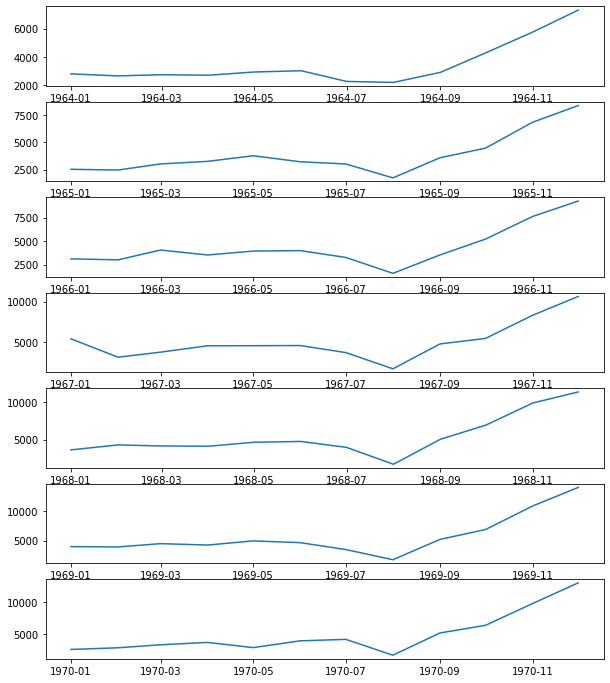

In [ ]:
# -----------SEASONAL LINE PLOT--------------
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
groups = dataset['1964':'1970'].groupby(Grouper(freq='A'))
years = DataFrame()
pyplot.figure(figsize = (10, 12))
i = 1
n_groups = len(groups)
for name, group in groups:
	pyplot.subplot((n_groups*100) + 10 + i)
	i += 1
	pyplot.plot(group)
pyplot.show()

## Density Plot
Reviewing plots of the density of observations can provide further insight into the structure of the data.

The example below creates a histogram and density plot of the observations without any temporal structure.

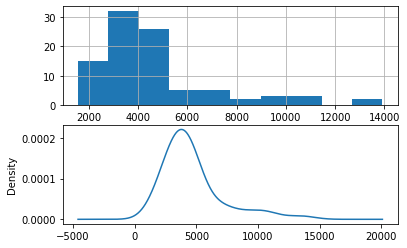

In [ ]:
# -------------DENSITY PLOT--------------
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
dataset.hist()
pyplot.subplot(212)
dataset.plot(kind='kde')
pyplot.show()

# Box and Whisker Plots
We can group the monthly data by year and get an idea of the spread of observations for each year and how this may be changing.

We do expect to see some trend (increasing mean or median), but it may be interesting to see how the rest of the distribution may be changing.

Some observations from reviewing the plots include:

*   The median values for each year (green line) may show an increasing trend.
*   The inter-quartile range or middle 50% of the data (blue boxes) does appear reasonably stable.
*   There are outliers each year (black hollow dots); these may be the tops or bottoms of the seasonal cycle.
*   The last year, 1970, does look different from the trend in prior years



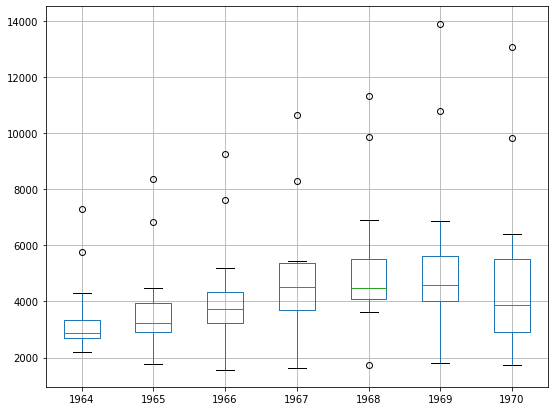

In [ ]:
# ----------BOX & WHISKER PLOT-------------
years = DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.boxplot(figsize=(9, 7))
pyplot.show()

# **ARIMA Models**
In this section, we will develop Autoregressive Integrated Moving Average, or ARIMA, models for the problem.

As such, this section is broken down into 3 steps:

*   Manually Configured ARIMA
*   Automatically configured ARIMA
*   Reviewing Residual Errors|



# Manually Configured ARIMA
The **ARIMA(p,d,q)** model requires three parameters and is traditionally configured manually.Analysis of the time series data assumes that we are working with a **stationary time series**.

The time series is almost certainly non-stationary. We can make it stationary this by **first differencing the series and using a statistical test to confirm that the result is stationary**.

The seasonality in the series is seemingly year-to-year. Seasonal data can be differenced by **subtracting the observation from the same time in the previous cycle**, in this case the same month in the previous year. This does mean that we will lose the first year of observations as there is no prior year to difference with.

The example below creates a deseasonalized version of the series and saves it to file **stationary.csv.**

ADF Statistic: -7.134898
p-value: 0.000000
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586


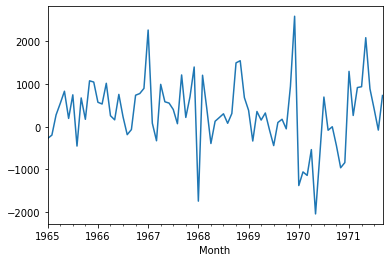

In [ ]:
from pandas import read_csv
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

X = dataset.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = dataset.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv', header=False)
# plot
stationary.plot()
pyplot.show()

The next first step is to select the **lag values** for the **Autoregression (AR) and Moving Average (MA) parameters, p and q** respectively.

We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

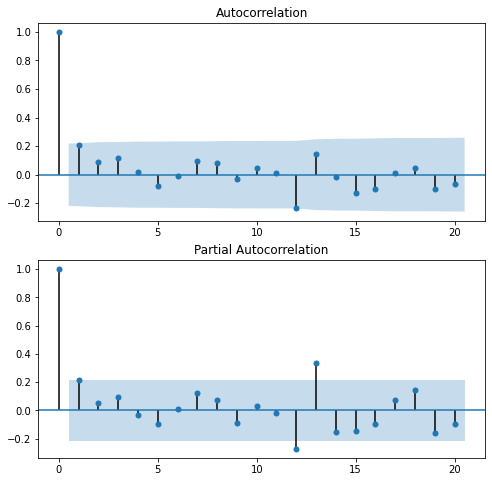

In [ ]:
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(8,8))
pyplot.subplot(211)
plot_acf(stationary, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(stationary, ax=pyplot.gca())
pyplot.show()

Below are some observations from the plots:

*   The ACF shows a significant lag for 1 month
*   The PACF shows a significant lag for 1 month, with perhaps some significant lag at 12 and 13 months
*   Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of AR and MA.

**A good starting point for the p and q values is also 1.**

This quick analysis suggests an ARIMA(1,0,1) on the stationary data may be a good starting point.

Experimentation shows that this configuration of ARIMA does not converge and results in errors by the underlying library. Further experimentation showed that adding one level of differencing to the stationary data made the model more stable. The model can be extended to **ARIMA(1,1,1)**.


In [ ]:
# evaluate manually configured ARIMA model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('/content/drive/My Drive/French Champagne Time series forecast/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=8281.617, Expected=8314.000
>Predicted=9929.826, Expected=10651.000
>Predicted=6137.123, Expected=3633.000
>Predicted=4017.108, Expected=4292.000
>Predicted=4155.148, Expected=4154.000
>Predicted=5112.222, Expected=4121.000
>Predicted=5203.516, Expected=4647.000
>Predicted=5053.482, Expected=4753.000
>Predicted=4129.898, Expected=3965.000
>Predicted=2077.483, Expected=1723.000
>Predicted=5178.607, Expected=5048.000
>Predicted=5813.854, Expected=6922.000
>Predicted=8585.157, Expected=9858.000
>Predicted=11103.941, Expected=11331.000
>Predicted=4197.308, Expected=4016.000
>Predicted=4873.929, Expected=3957.000
>Predicted=4724.829, Expected=4510.000
>Predicted=4619.576, Expected=4276.000
>Predicted=5134.140, Expected=4968.000
>Predicted=5216.122, Expected=4677.000
>Predicted=4414.585, Expected=3523.000
>Predicted=2114.082, Expected=1821.000
>Predicted=5388.371, Expected=5222.000
>Predicted=7244.612, Expected=6872.000
>Predicted=10158.450, Expected=10803.000
>Predicted=11633.133

Running this example results in an RMSE of **966.176**, which is dramatically better than the persistence RMSE of **3186.501**.

# Grid Search ARIMA Hyperparameters
In this section, we will search values of p, d, and q for combinations (skipping those that fail to converge), and find the combination that results in the best performance on the test set. We will use a grid search to explore all combinations in a subset of integer values.

Specifically, we will search all combinations of the following parameters:

*   p : 0 to 6
*   d : 0 to 2
*   q : 0 to 6





In [ ]:
# grid search ARIMA parameters for time series
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = read_csv('/content/drive/My Drive/French Champagne Time series forecast/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=947.677
ARIMA(0, 0, 1) RMSE=948.736
ARIMA(0, 0, 2) RMSE=973.850
ARIMA(0, 0, 3) RMSE=987.539
ARIMA(0, 0, 4) RMSE=1034.432
ARIMA(0, 0, 5) RMSE=1044.996
ARIMA(0, 1, 0) RMSE=1157.460
ARIMA(0, 1, 1) RMSE=979.097
ARIMA(0, 2, 0) RMSE=1951.373
ARIMA(0, 2, 1) RMSE=1183.822
ARIMA(1, 0, 0) RMSE=945.305
ARIMA(1, 1, 0) RMSE=1080.588
ARIMA(1, 1, 1) RMSE=966.176
ARIMA(1, 2, 0) RMSE=1572.459
ARIMA(2, 0, 0) RMSE=963.295
ARIMA(2, 0, 1) RMSE=1013.215
ARIMA(2, 1, 0) RMSE=1040.239
ARIMA(2, 1, 1) RMSE=981.373
ARIMA(2, 2, 0) RMSE=1360.312
ARIMA(2, 2, 1) RMSE=1070.089
ARIMA(3, 0, 0) RMSE=976.351
ARIMA(3, 0, 1) RMSE=984.779
ARIMA(3, 1, 0) RMSE=1038.489
ARIMA(3, 2, 0) RMSE=1257.302
ARIMA(4, 0, 0) RMSE=1004.121
ARIMA(4, 1, 0) RMSE=1056.074
ARIMA(4, 2, 0) RMSE=1240.092
ARIMA(4, 2, 1) RMSE=1118.307
ARIMA(5, 0, 0) RMSE=1019.967
ARIMA(5, 1, 0) RMSE=1052.399
ARIMA(6, 0, 0) RMSE=1030.144
ARIMA(6, 0, 1) RMSE=1095.710
ARIMA(6, 1, 0) RMSE=1028.031
Best ARIMA(1, 0, 0) RMSE=945.305


We will select this **ARIMA(1, 0, 0)** model going forward.

# Review Residual Errors
A good final check of a model is to review residual forecast errors.

Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

We can check this by using summary statistics and plots to investigate the residual errors from the ARIMA(0, 0, 1) model. The example below calculates and summarizes the residual forecast errors.

                 0
count    47.000000
mean   -196.825871
std     934.582501
min   -2319.579513
25%    -680.802901
50%    -238.533918
75%     352.371029
max    2190.639261


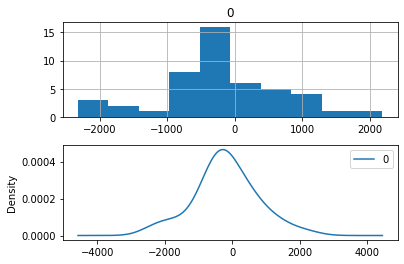

In [ ]:
# summarize ARIMA forecast residuals
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('/content/drive/My Drive/French Champagne Time series forecast/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,0,0))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

We can see that the distribution has a right shift and that the mean is non-zero at -196.825871.

We could use this information to bias-correct predictions by adding the mean residual error of -196.825871 to each forecast made

RMSE: 924.587
                  0
count  4.700000e+01
mean   1.137911e-07
std    9.345825e+02
min   -2.122754e+03
25%   -4.839770e+02
50%   -4.170805e+01
75%    5.491969e+02
max    2.387465e+03


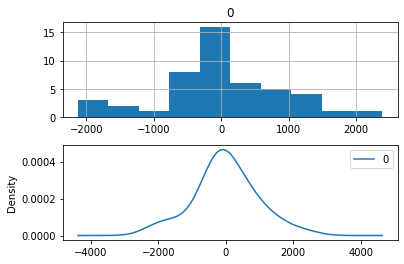

In [ ]:
# plots of residual errors of bias corrected forecasts
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('/content/drive/My Drive/French Champagne Time series forecast/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = -196.825871
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,0,0))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

The performance of the predictions is improved very slightly from 945.305 to 924.587, which may or may not be significant.

The summary of the forecast residual errors shows that the mean was indeed moved to a value very close to zero.

# Finalize Model
Finalizing the model involves fitting an ARIMA model on the entire dataset, in this case on a transformed version of the entire dataset.

Once fit, the model can be saved to file for later use.

The example below trains an ARIMA(1,0,0) model on the dataset and saves the whole fit object and the bias to file.

The example below saves the fit model to file in the correct state so that it can be loaded successfully later

In [ ]:
# save finalized model
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# load data
series = read_csv('/content/drive/My Drive/French Champagne Time series forecast/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(1,0,0))
model_fit = model.fit()
# bias constant, could be calculated from in-sample mean residual
bias = -196.825871
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

Running the example creates two local files:

*   *model.pkl* : This is the ARIMAResult object from the call to ARIMA.fit(). This includes the coefficients and all other internal data returned when fitting the model.
*  *model_bias.npy* : This is the bias value stored as a one-row, one-column NumPy array.




# Make Prediction
The example below loads the model, makes a prediction for the next time step, and prints the prediction.

In [ ]:
# load finalized model and make a prediction
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMAResults
import numpy

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

series = read_csv('/content/drive/My Drive/French Champagne Time series forecast/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 6631.852


# Validate Model

In the test harness section, we saved the final 12 months of the original dataset in a separate file to validate the final model.

We can load this validation.csv file now and use it see how well our model really is on “unseen” data.

>Predicted=6631.852, Expected=6981.000
>Predicted=10015.500, Expected=9851.000
>Predicted=13129.562, Expected=12670.000
>Predicted=3889.477, Expected=4348.000
>Predicted=3296.031, Expected=3564.000
>Predicted=4418.304, Expected=4577.000
>Predicted=4784.514, Expected=4788.000
>Predicted=5078.498, Expected=4618.000
>Predicted=4826.955, Expected=5312.000
>Predicted=4765.962, Expected=4298.000
>Predicted=1623.482, Expected=1413.000
>Predicted=5926.939, Expected=5877.000
RMSE: 339.181


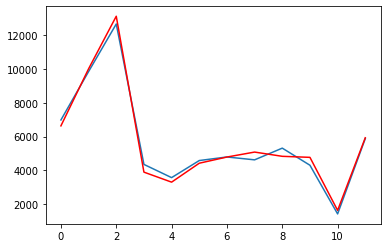

In [ ]:
# load and evaluate the finalized model on the validation dataset
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load and prepare datasets
dataset = read_csv('/content/drive/My Drive/French Champagne Time series forecast/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = read_csv('/content/drive/My Drive/French Champagne Time series forecast/validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,0,0))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

The final RMSE for the validation period is predicted at 339.181 million sales.